<form action="index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# Algae Example
Author(s): Paul Miles | Date Created: June 18, 2018

This is a simplified lake algae dynamics model. We consider phytoplankton $A$, zooplankton $Z$ and nutrition $P$ (eg. phosphorus) available for $A$ in the water. The system is affected by the water outflow/inflow $Q$, incoming phosphorus load $P_{in}$ and temperature $T$. It is described as a simple predator - pray dynamics between $A$ and $Z$. The growth of $A$ is limited by the availability of $P$ and it depends on the water temperature $T$. The inflow/outflow $Q$ affects both $A$ and $P$, but not $Z$.

In [1]:
# import required packages
import numpy as np
import os
import scipy.io as sio
from scipy.integrate import odeint
from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting import MCMCPlotting
import matplotlib.pyplot as plt
import pymcmcstat
print(pymcmcstat.__version__)
np.seterr(over='ignore');

1.9.0


The data is saved in a `.mat` file as the original example comes from the Matlab.  We extract the necessary data as follows

In [2]:
# load Algae data
algaedata = sio.loadmat('data_files' + os.sep + 'algaedata.mat')
# extract dictionary contents
adata = algaedata['data']
tx = adata['xdata'][0][0]
ty = adata['ydata'][0][0]
xlbls = adata['xlabels'][0][0][0]
ylbls = adata['ylabels'][0][0][0]

# Define Sum-of-Squares and Model Functions
The model function requires evaluation of a system of ODEs.  The solution implemented below is non-optimal.  It is intended to serve as an example of how to couple and ODE system type problem with [pymcmcstat](https://prmiles.wordpress.ncsu.edu/codes/python-packages/pymcmcstat/).  Optimizing your ODE system solver is left to the user's discretion.

In [53]:
def algaess(theta, data):
    # sum-of-squares function for algae example
    ndp, nbatch = data.shape[0]
    time = data.ydata[0][:, 0]
    ydata = data.ydata[0][:, 1:4]
    xdata = data.user_defined_object[0]
    # last 3 parameters are the initial states
    y0 = np.array(theta[-3:])
    # evaluate model
    tmodel, ymodel = algaefun(time, theta, y0, xdata)
    res = ymodel - ydata.reshape(ymodel.shape)
    ss = (res**2).sum(axis=0)
    return ss    

def algaefun(time, theta, y0, xdata):
    """
    Evaluate Ordinary Differential Equation
    """
    sol = odeint(algaesys, y0, time, args=(theta, xdata))
    return time, sol
    
def algaesys(y, t, theta, xdata):
    """
    Model System
    """
    A = y[0]
    Z = y[1]
    P = y[2]
    # control variables are assumed to be saved at each time unit interval
    idx = int(np.ceil(t)) - 1    
    if idx >= 120:
        idx = 119
    QpV = xdata[idx, 1]
    T = xdata[idx, 2]
    Pin = xdata[idx, 3]
    # model parameters
    mumax = theta[0]
    rhoa = theta[1]
    rhoz = theta[2]
    k = theta[3]
    alpha = theta[4]
    th = theta[5]
    mu = mumax*(th**(T-20))*P*((k+P)**(-1))
    dotA = (mu - rhoa - QpV - alpha*Z)*A
    dotZ = alpha*Z*A - rhoz*Z
    dotP = -QpV*(P-Pin) + (rhoa-mu)*A + rhoz*Z
    ydot = np.array([dotA, dotZ, dotP])
    return ydot

# Initialize MCMC Object and Setup Simulation
- Define data structure
- Assign parameters and define constraints
- Set simulation options and model settings

In [59]:
# initialize MCMC object
mcstat = MCMC()
# initialize data structure 
mcstat.data.add_data_set(x=tx[:, 0],
                         y=ty[:, 0:4],
                         user_defined_object=tx)
# initialize parameter array
#theta = [0.5, 0.03, 0.1, 10, 0.02, 1.14, 0.77, 1.3, 10]
# add model parameters
mcstat.parameters.add_model_parameter(name='mumax', theta0=0.5, minimum=0)
mcstat.parameters.add_model_parameter(name='rhoa', theta0=0.03, minimum=0)
mcstat.parameters.add_model_parameter(name='rhoz', theta0=0.1, minimum=0)
mcstat.parameters.add_model_parameter(name='k', theta0=10, minimum=0)
mcstat.parameters.add_model_parameter(name='alpha', theta0=0.02, minimum=0)
mcstat.parameters.add_model_parameter(name='th', theta0=1.14, minimum=0,
                                      maximum=np.inf, prior_mu=0.14,
                                      prior_sigma=0.2)
# initial values for the model states
mcstat.parameters.add_model_parameter(name='A0', theta0=0.77, minimum=0,
                                      maximum=np.inf, prior_mu=0.77,
                                      prior_sigma=2)
mcstat.parameters.add_model_parameter(name='Z0', theta0=1.3, minimum=0,
                                      maximum=np.inf, prior_mu=1.3,
                                      prior_sigma=2)
mcstat.parameters.add_model_parameter(name='P0', theta0=10, minimum=0,
                                      maximum=np.inf, prior_mu=10,
                                      prior_sigma=2)

# Generate options
mcstat.simulation_options.define_simulation_options(
    nsimu=1.0e3, updatesigma=True)
# Define model object:
mcstat.model_settings.define_model_settings(
    sos_function=algaess,
    S20=np.array([1, 1, 2]),
    N0=np.array([4, 4, 4]))

The code takes some time to run, so here we simply check to make sure the data structure can be processed using our sum-of-squares function.  Note, we have separate sum-of-squares for each quantity of interest and there will be a separate error variance for each as well.

In [60]:
# check model evaluation
theta = [0.5, 0.03, 0.1, 10, 0.02, 1.14, 0.77, 1.3, 10]
ss = algaess(theta, mcstat.data)
print('ss = {}'.format(ss))

ss = [ 930.44890289  521.2441601  1278.11736803]


# Run simulation
- We run an initialize sequence of 1000, then restart and perform another 5000

In [61]:
# Run simulation
mcstat.run_simulation()
# Rerun starting from results of previous run
mcstat.simulation_options.nsimu = int(5.0e3)
mcstat.run_simulation(use_previous_results=True)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
     mumax:      0.50 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
      rhoa:      0.03 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
      rhoz:      0.10 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
         k:     10.00 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
     alpha:      0.02 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
        th:      1.14 [ 0.00e+00,       inf] N(     0.14,     0.20^2)
        A0:      0.77 [ 0.00e+00,       inf] N(     0.77,     2.00^2)
        Z0:      1.30 [ 0.00e+00,       inf] N(     1.30,     2.00^2)
        P0:     10.00 [ 0.00e+00,       inf] N(    10.00,     2.00^2)
 [-----------------100%-----------------] 1000 of 1000 complete in 98.0 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
     mumax:      0.39 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
      rhoa:      0.02 [ 0.00e+00,       inf

# Extract results and plot chain diagnostics
- chain panel
- density panel
- pairwise correlation panel



------------------------------
name      :       mean        std     MC_err        tau     geweke
mumax     :     0.8079     0.2894     0.0537   193.0222     0.7238
rhoa      :     0.0482     0.0224     0.0041   167.3812     0.9930
rhoz      :     0.0995     0.0052     0.0004    20.5428     0.9907
k         :    26.5229    14.2116     2.8011   202.6484     0.5287
alpha     :     0.0239     0.0013     0.0001    46.3865     0.9603
th        :     1.0018     0.0143     0.0018    59.1035     0.9910
A0        :     0.8684     0.2815     0.0304    33.5992     0.9587
Z0        :     1.8728     0.4502     0.0474    46.1744     0.9658
P0        :     8.9506     0.8791     0.0984    54.7130     0.9283
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 21.78%
Stage 2: 50.86%
Net    : 72.64% -> 3632/5000
---------------
Chain provided:
Net    : 72.91% -> 2551/3499
---------------
Note, the net acceptance rate from the results dictionary
may be

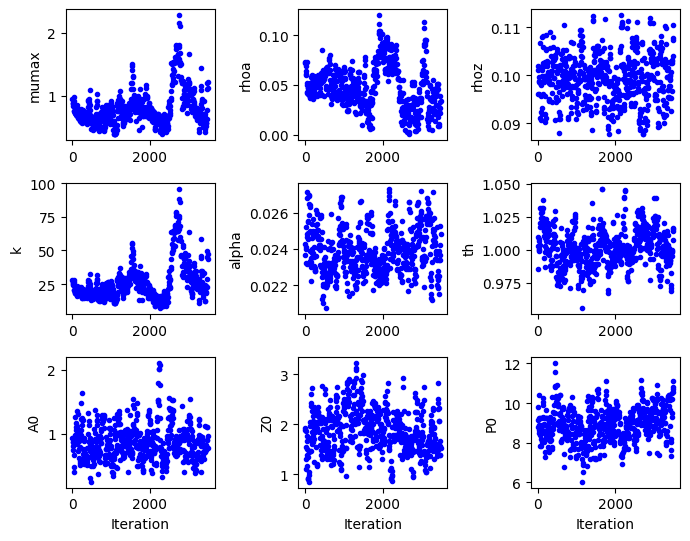

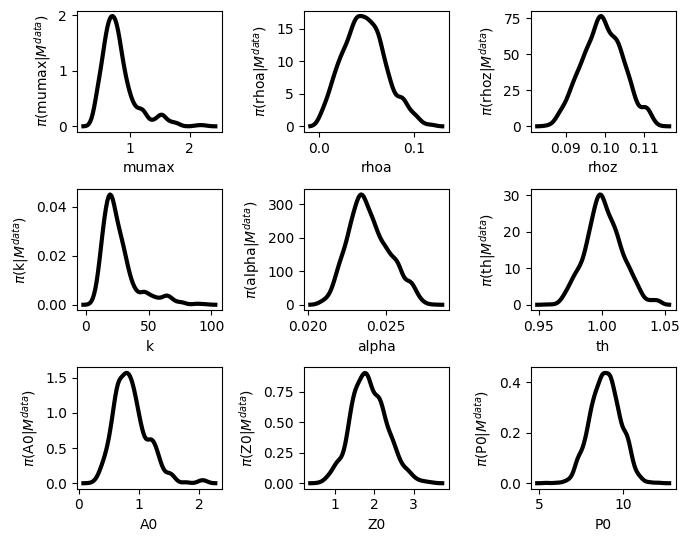

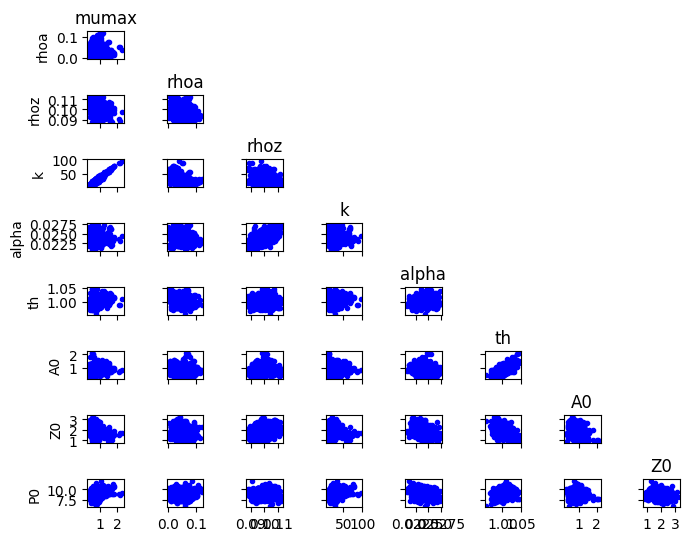

In [72]:
# extract info from results
results = mcstat.simulation_results.results
burnin = int(results['nsimu']/2)
chain = results['chain'][burnin:, :]
s2chain = results['s2chain'][burnin:, :]
names = results['names'] # parameter names

# display chain stats
mcstat.chainstats(chain, results)

from pymcmcstat import mcmcplot as mcp
settings = dict(
    fig=dict(figsize=(7, 6))
)
# plot chain panel
mcp.plot_chain_panel(chain, names, settings)
# plot density panel
mcp.plot_density_panel(chain, names, settings)
# pairwise correlation
f = mcp.plot_pairwise_correlation_panel(chain, names, settings)

# Generate prediction/credible intervals for each quantity of interest
## Generate intervals

In [75]:
from pymcmcstat import propagation as up

def predmodel(q, data):
    obj = data.user_defined_object[0]
    time = obj[:, 0]
    xdata = obj
    # last 3 parameters are the initial states
    y0 = np.array(q[-3:])
    # evaluate model
    ymodel = np.zeros([time.size, 3])
    tmodel, ymodel = algaefun(time, q, y0, xdata)
    return ymodel

pdata = mcstat.data
intervals = up.calculate_intervals(chain, results, pdata, predmodel,
                                  waitbar=True, s2chain=s2chain)

 [-----------------100%-----------------] 500 of 500 complete in 25.3 sec

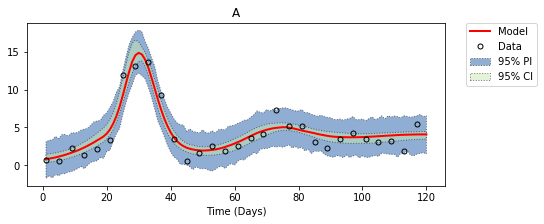

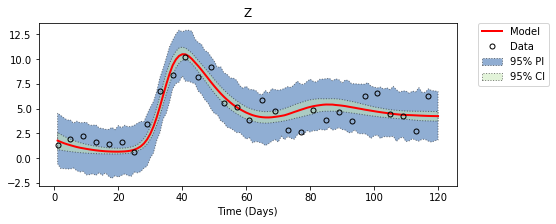

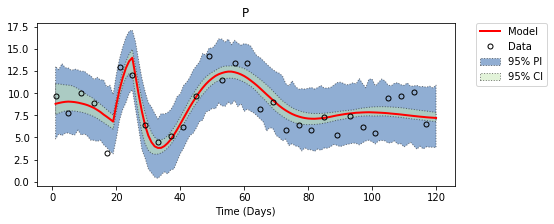

In [76]:
data_display = dict(
    marker='o',
    color='k',
    mfc='none',
    label='Data')
model_display = dict(
    color='r')
interval_display = dict(
    alpha=0.5)
for ii, interval in enumerate(intervals):
    fig, ax = up.plot_intervals(interval,
                                time=mcstat.data.xdata[0],
                                ydata=mcstat.data.ydata[0][:, ii + 1],
                                xdata=mcstat.data.ydata[0][:, 0],
                                data_display=data_display,
                                model_display=model_display,
                                interval_display=interval_display,
                                ciset=dict(colors=['#c7e9b4']),
                                piset=dict(colors=['#225ea8']),
                                figsize=(7.5, 3))
    ax.set_ylabel('')
    ax.set_title(ylbls[ii + 1][0])
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('Time (Days)')

# Old way of generating/plotting intervals
I have included the original procedure for generating intervals with models of this form.  One of the advantages of using the new `propagation` module is that it is more flexible with regard to the data structure and plotting options.  However, the original method still exists for those who are interested.  Future features will not be added to the `PredictionIntervals` class.
## Generate intervals

In [77]:
def predmodelfun(data, theta):
    obj = data.user_defined_object[0]
    time = obj[:, 0]
    xdata = obj
    # last 3 parameters are the initial states
    y0 = np.array(theta[-3:])
    # evaluate model    
    tmodel, ymodel = algaefun(time, theta, y0, xdata)
    return ymodel

mcstat.PI.setup_prediction_interval_calculation(
    results=results,
    data=mcstat.data,
    modelfunction=predmodelfun)
mcstat.PI.generate_prediction_intervals(
    nsample=500,
    calc_pred_int=True,
    waitbar=True)

Generating credible/prediction intervals:

 [-----------------100%-----------------] 500 of 500 complete in 25.8 sec
Interval generation complete



## Plot intervals

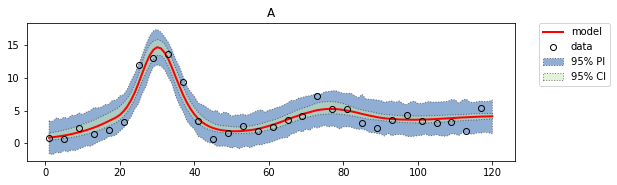

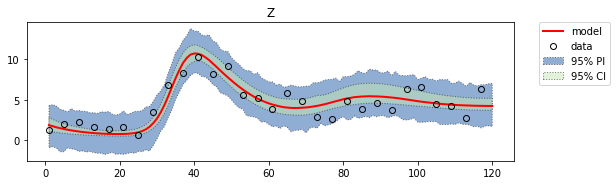

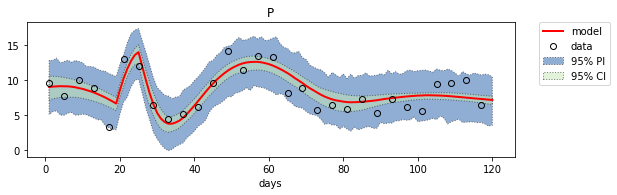

In [78]:
# plot prediction intervals
fighandle, axhandle = mcstat.PI.plot_prediction_intervals(
    adddata=False,
    addlegend=False,
    figsizeinches=[7.5, 8])
for ii in range(3):
    axhandle[ii].plot(mcstat.data.ydata[0][:, 0],
                      mcstat.data.ydata[0][:, ii + 1],
                      'ko', mfc='none', label='data')
    axhandle[ii].set_ylabel('')
    axhandle[ii].set_title(ylbls[ii + 1][0])
    axhandle[ii].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axhandle[-1].set_xlabel('days');